# Comparison between classic and roulette-based decision trees

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

import tree

# Data-reading function

In [18]:
def read_data(datapath: str, state: int):
    data = pd.read_csv(datapath)
    features = data.columns.values
    X, y = data.values[:, :-1], data.values[:, -1].reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=state
    )
    return X_train, X_test, y_train, y_test, features

SEED = 217

In [19]:
def analyze_trees(datapath: str, depths: list[int], iterations: int=10):
    X_train, X_test, y_train, y_test, features = read_data(datapath, SEED)
    results = {
        "ClassicTree": [],
        "RouletteTree": []
    }
    y_test = y_test.astype(str)
    
    for depth in depths:
        # Analyze ClassicTree (only once per depth)
        classic_tree = tree.ClassicTree(features)
        classic_tree.max_depth = depth
        classic_tree.fit(X_train, y_train)
        y_pred = classic_tree.predict(X_test)
        y_pred = y_pred.astype(str)
        
        results["ClassicTree"].append({
            "depth": depth,
            "confusion_matrix": confusion_matrix(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
            "recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
            "f1": f1_score(y_test, y_pred, average="weighted"),
            "accuracy": accuracy_score(y_test, y_pred)
        })
        
        # Analyze RouletteTree (multiple iterations per depth)
        for i in range(iterations):
            roulette_tree = tree.RouletteTree(features)
            roulette_tree.max_depth = depth
            roulette_tree.fit(X_train, y_train)
            y_pred = roulette_tree.predict(X_test)
            y_pred = y_pred.astype(str)
            
            results["RouletteTree"].append({
                "depth": depth,
                "iteration": i,
                "confusion_matrix": confusion_matrix(y_test, y_pred),
                "precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
                "recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
                "f1": f1_score(y_test, y_pred, average="weighted"),
                "accuracy": accuracy_score(y_test, y_pred)
            })
    return results

def visualize_comparison(results, title):
    depths = sorted(set(res["depth"] for res in results["ClassicTree"]))
    metrics = ["precision", "recall", "f1", "accuracy"]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)
    
    for i, metric in enumerate(metrics):
        # Metrics for ClassicTree
        classic_values = [
            next(res[metric] for res in results["ClassicTree"] if res["depth"] == depth)
            for depth in depths
        ]
        
        # Metrics for RouletteTree
        roulette_averages = [
            np.mean([res[metric] for res in results["RouletteTree"] if res["depth"] == depth])
            for depth in depths
        ]
        roulette_min = [
            np.min([res[metric] for res in results["RouletteTree"] if res["depth"] == depth])
            for depth in depths
        ]
        roulette_max = [
            np.max([res[metric] for res in results["RouletteTree"] if res["depth"] == depth])
            for depth in depths
        ]
        
        # Plot metrics
        axes[i%2][i//2].plot(depths, classic_values, label="ClassicTree (Avg)", marker="o", color="blue")
        axes[i%2][i//2].plot(depths, roulette_averages, label="RouletteTree (Avg)", marker="s", color="green")
        axes[i%2][i//2].fill_between(depths, roulette_min, roulette_max, color="green", alpha=0.2, label="RouletteTree (Min-Max)")
        axes[i%2][i//2].set_title(metric.capitalize())
        axes[i%2][i//2].set_xlabel("Depth")
        axes[i%2][i//2].set_ylabel(metric.capitalize())
        axes[i%2][i//2].legend()
        axes[i%2][i//2].grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Plot Confusion Matrices for a chosen depth
    selected_depth = depths[len(depths) // 2]
    classic_cm = next(
        res["confusion_matrix"]
        for res in results["ClassicTree"]
        if res["depth"] == selected_depth
    )
    roulette_cms = [
        res["confusion_matrix"]
        for res in results["RouletteTree"]
        if res["depth"] == selected_depth
    ]
    avg_roulette_cm = np.mean(roulette_cms, axis=0)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Confusion Matrices at Depth {selected_depth}", fontsize=16)
    
    sns.heatmap(classic_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("ClassicTree")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    
    sns.heatmap(avg_roulette_cm, annot=True, fmt=".1f", cmap="Greens", ax=axes[1])
    axes[1].set_title("RouletteTree (Avg)")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Processing dataset: nursery.csv


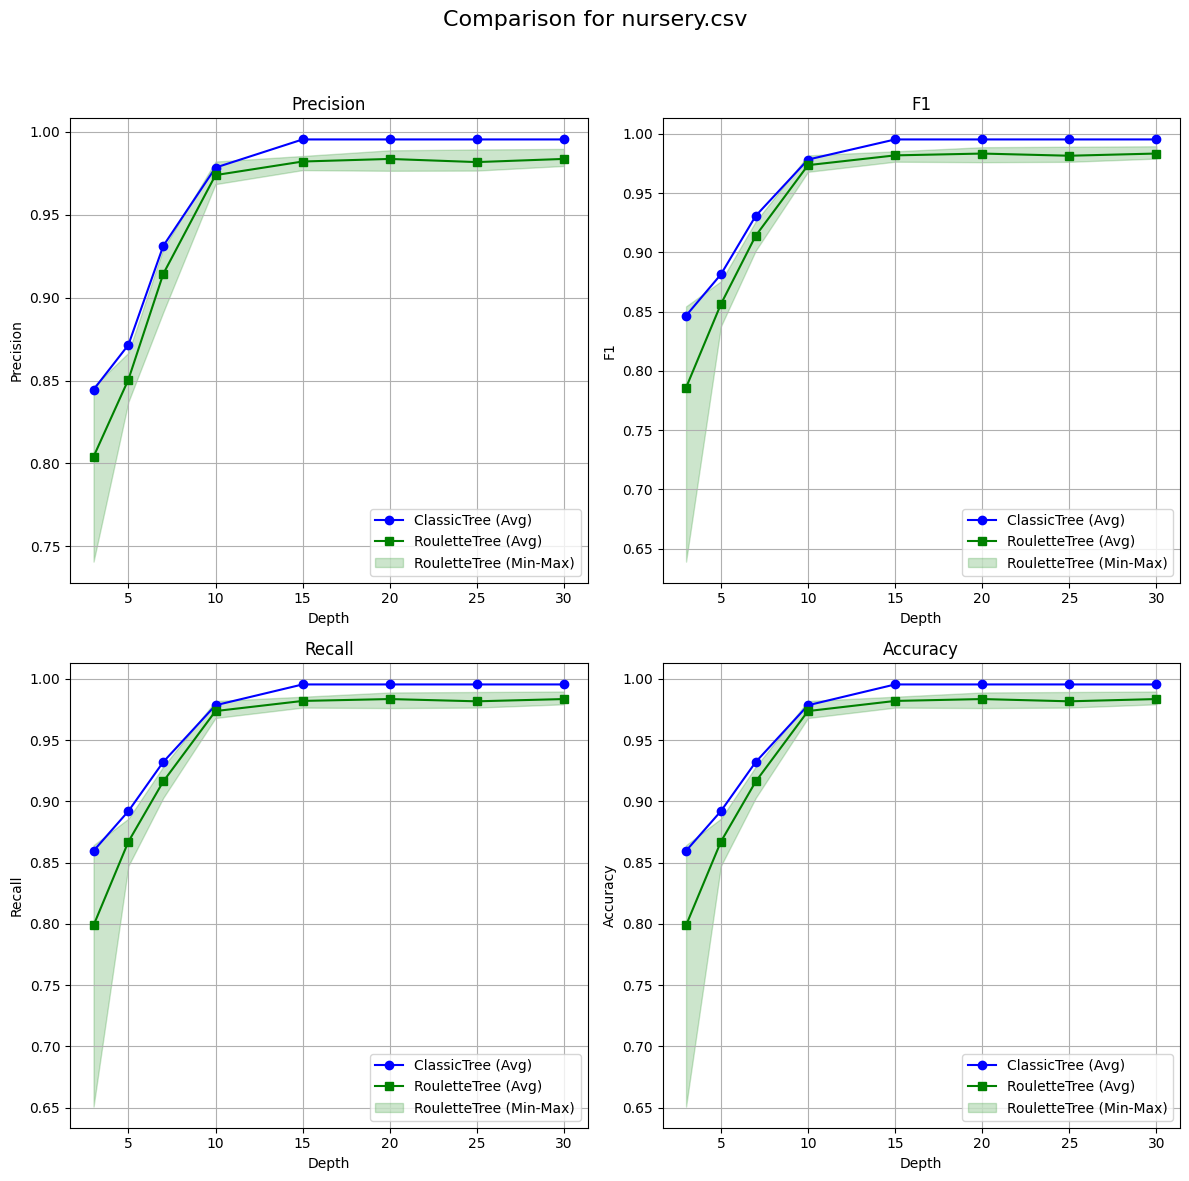

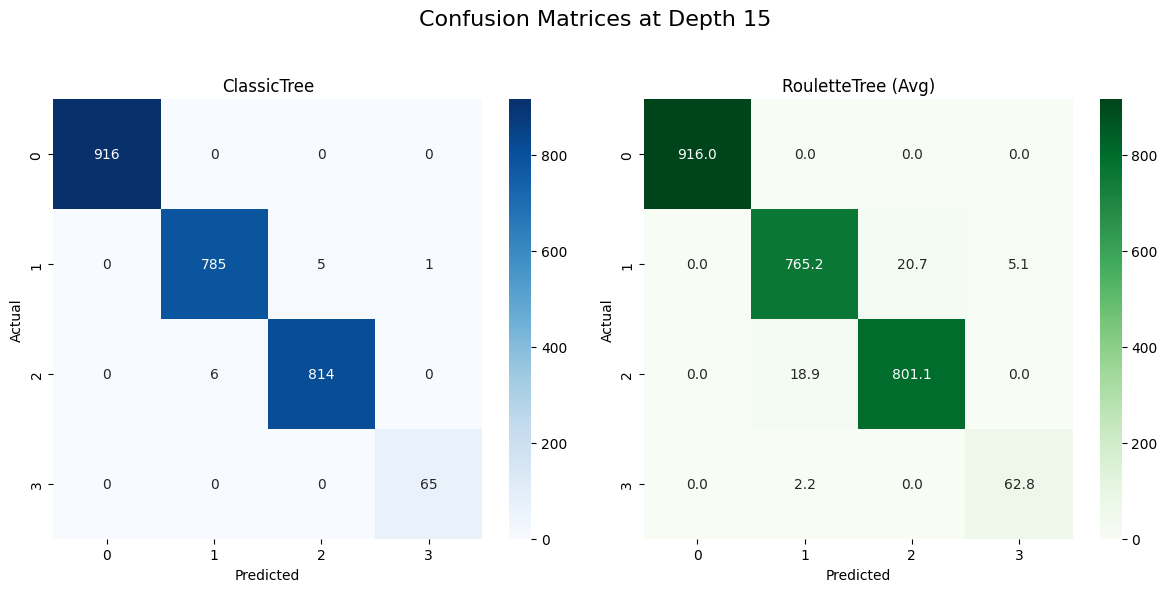

Processing dataset: user_behavior_dataset.csv


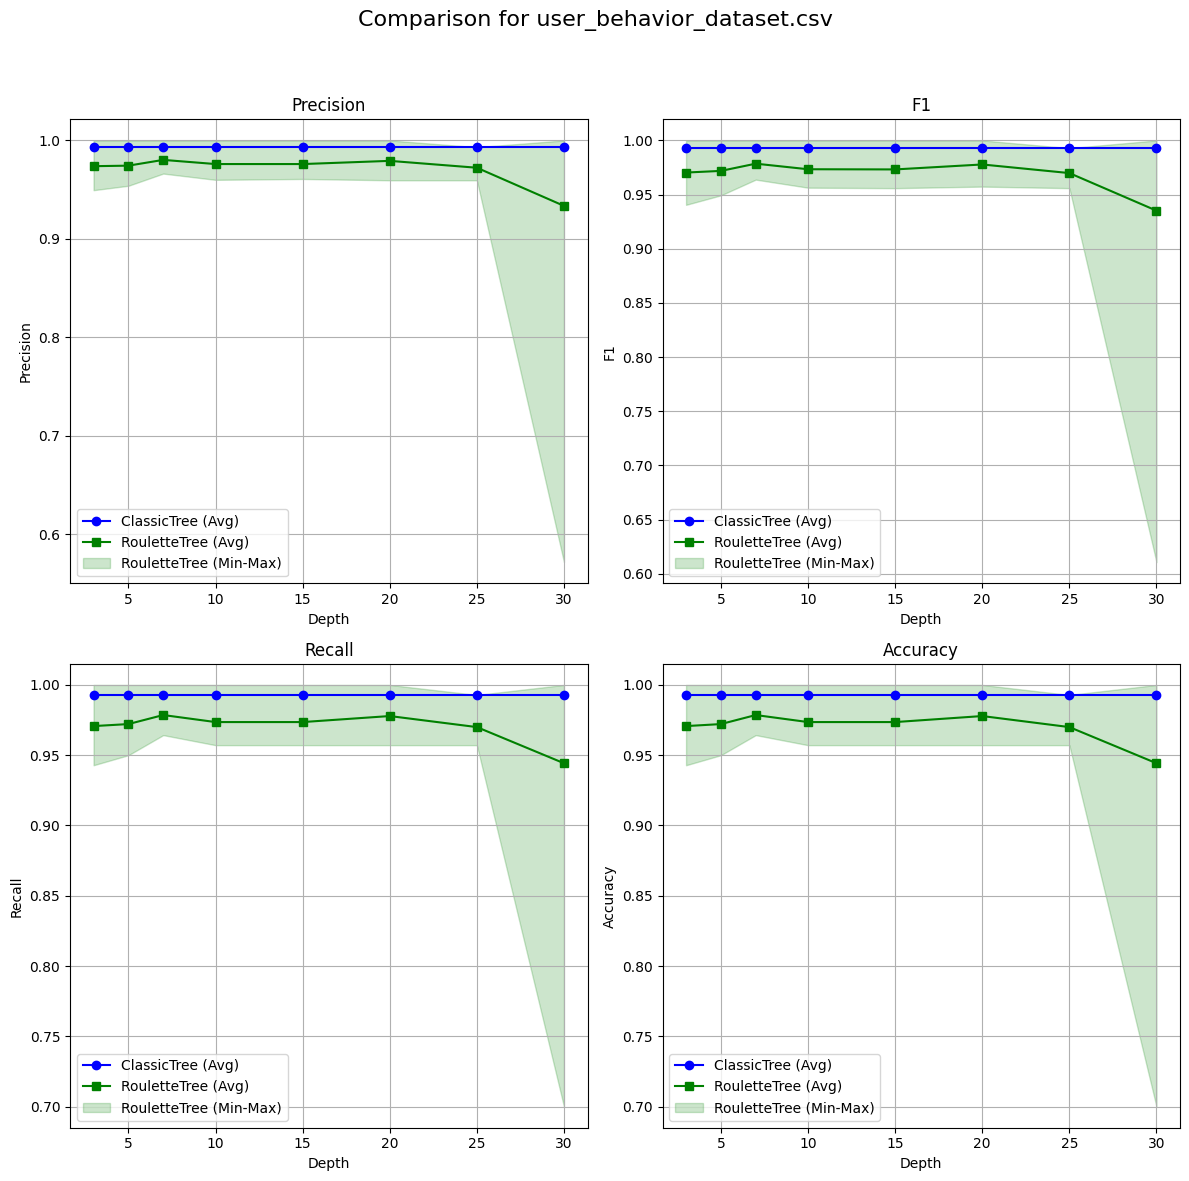

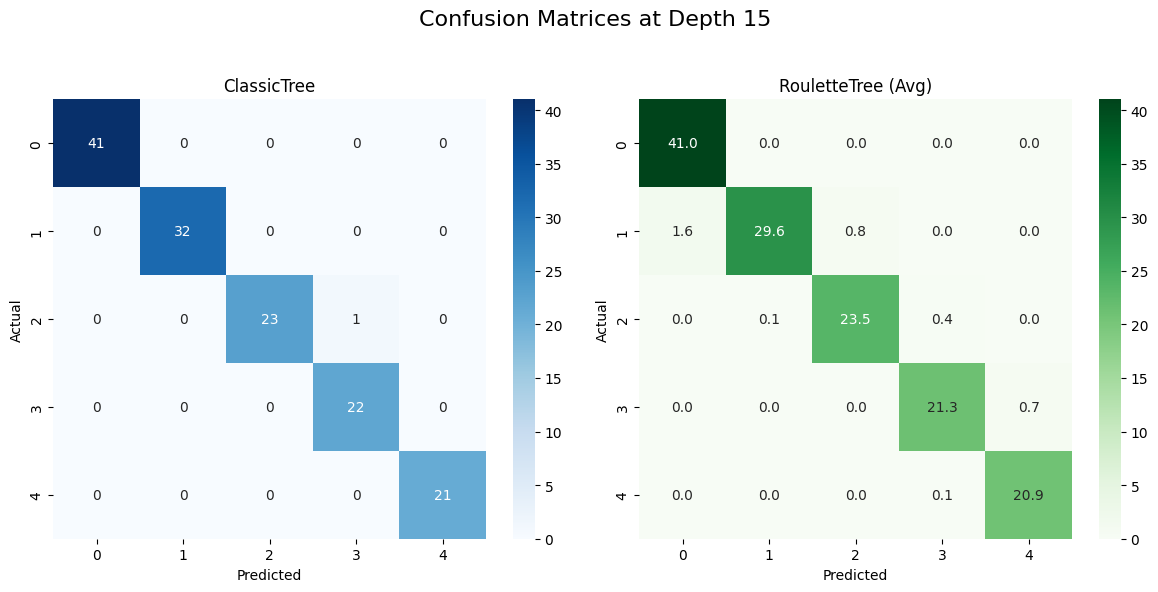

Processing dataset: winequality-red.csv


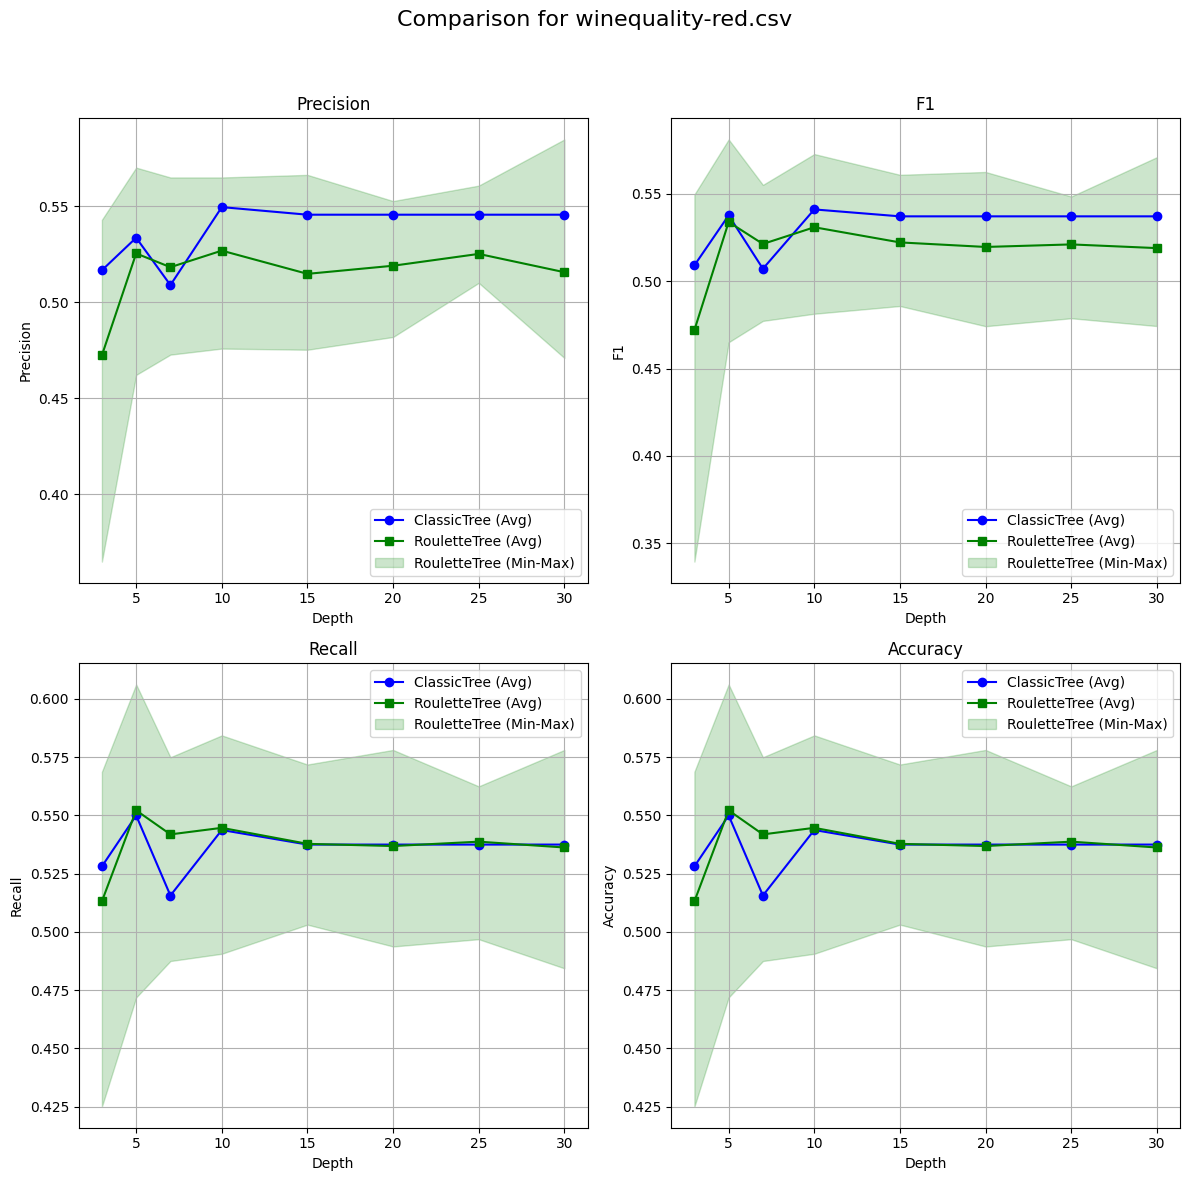

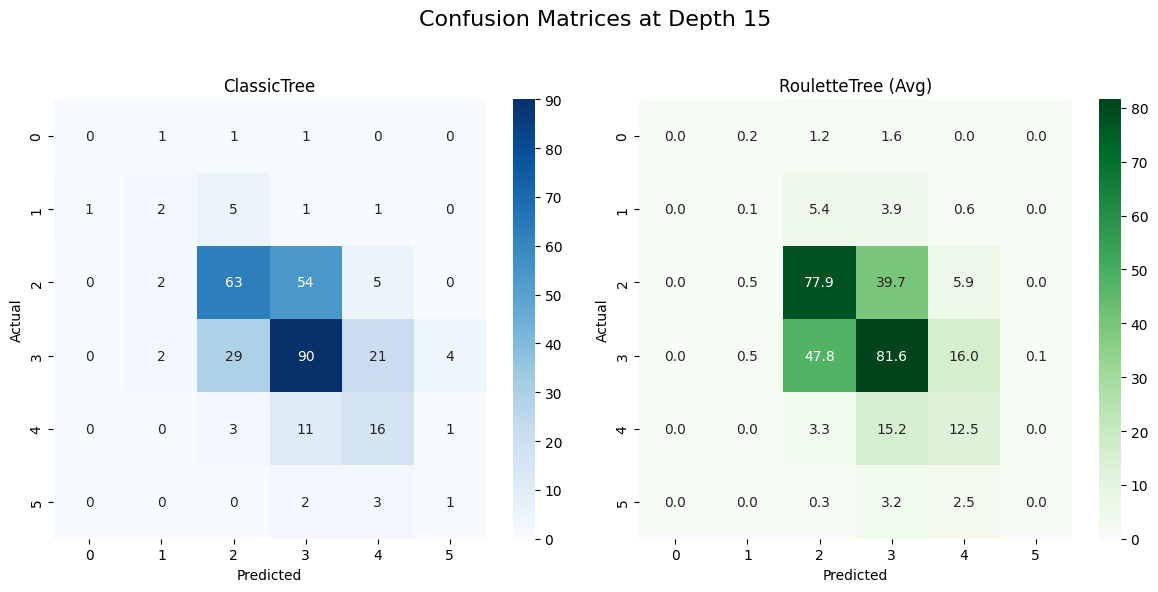

Processing dataset: loan_data.csv


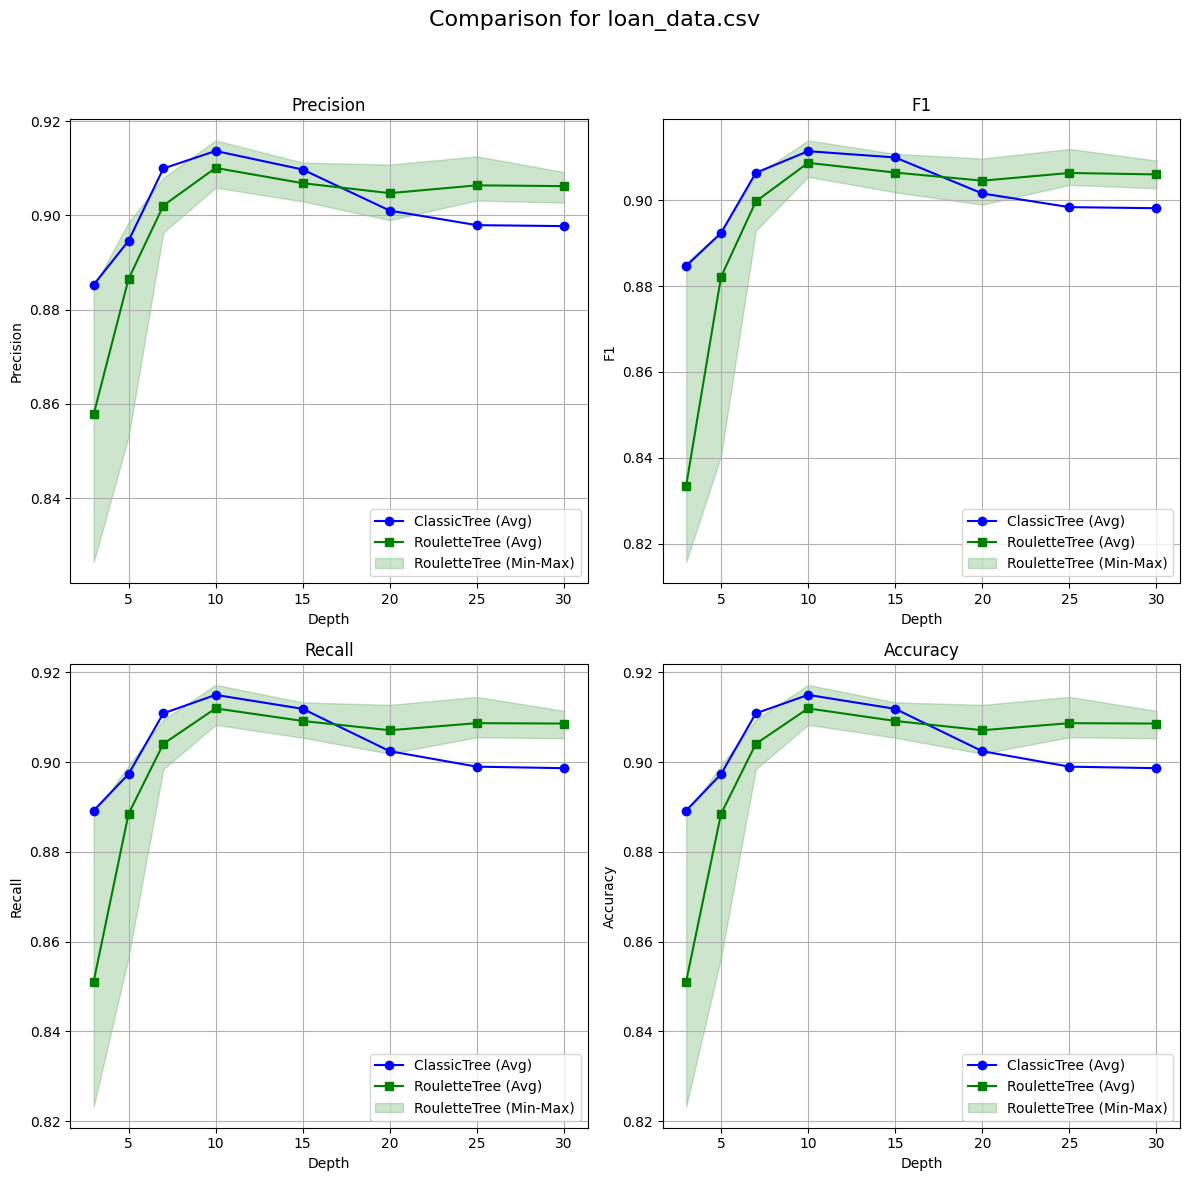

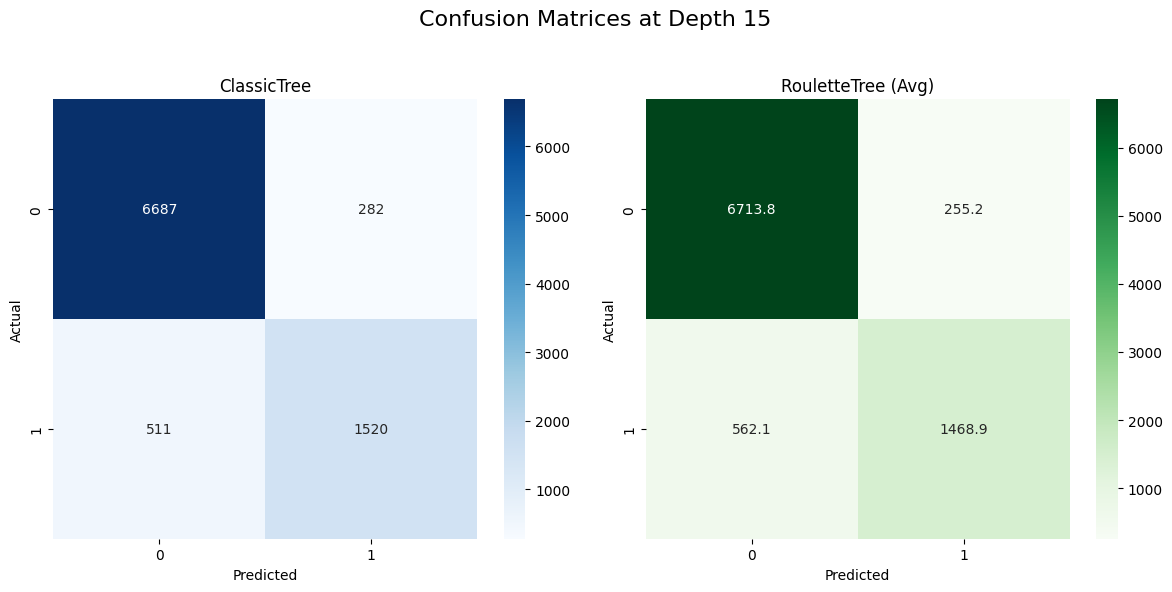

In [20]:
DATA_DIR = "../data/"

DATA_PATHS = [
    "nursery.csv", "user_behavior_dataset.csv", "winequality-red.csv", "loan_data.csv"
]

depths = [3, 5, 7, 10, 15, 20, 25, 30]  # Depths to test
iterations = 10  # Number of iterations for RouletteTree
all_results = {}

for dataset_path in DATA_PATHS:
    print(f"Processing dataset: {dataset_path}")
    
    # Analyze ClassicTree and RouletteTree
    results = analyze_trees(DATA_DIR + dataset_path, depths, iterations)
    visualize_comparison(results, f"Comparison for {dataset_path}")
    
    # Save results
    all_results[dataset_path] = results